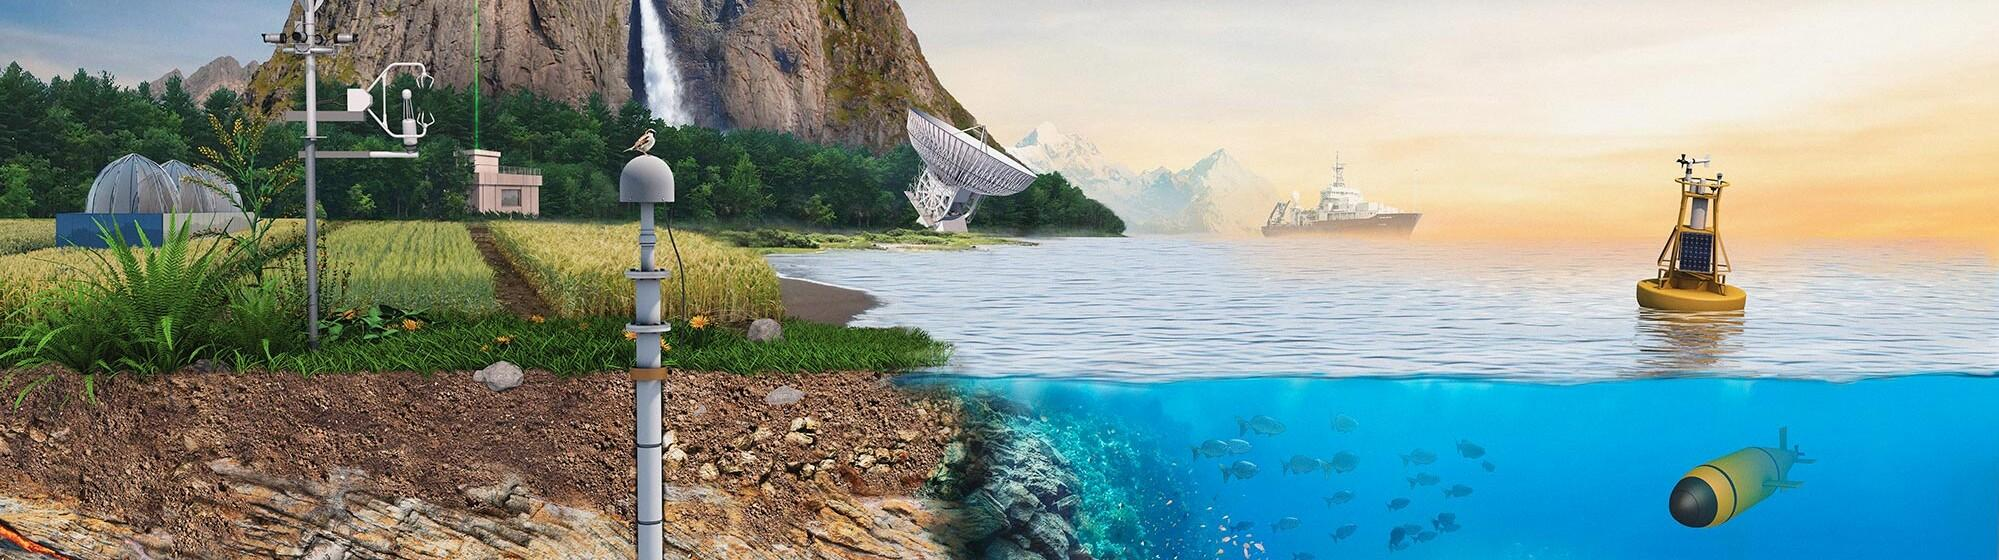

# **A tutorial on how to plot ENVRI atmospheric and marine stations**

The ENVRI-Hub has a [Catalogue of Services](https://hubtest.envri-fair.eu/cservicesmain) where you can search for metadata of the ENV RIs, which will lead you to the data you need. 
The ENVRI-Hub (and the Catalogue of Services) are growing, so at this point you won't find every ENVRI service there (we are working on it :) )

This notebook shows how you can make use of some of the already existing APIs within ENVRI RIs and plot their data.

**Some of the Atmospheric RIs within ENVRI have joined efforts and prepared a Scientific Demonstrator with an API in which you can easily fetch both stations and variables from RIs (ICOS, IAGOS, SIOS and ACTRIS) of the Atmospheric domain, see https://github.com/damienboulanger/envri-wp8-demonstrator/ .**

In this notebook, we show you another way of doing this exercise. Having both alternatives, you can use them in whichever way is more convenient for you!

We will be plotting the location and metadata of atmospheric stations from:
 
- [IAGOS](https://www.iagos.org/),[ICOS](https://www.icos-cp.eu/), [SIOS](https://sios-svalbard.org/) and [ACTRIS](https://www.actris.eu/)

and marine stations from:
- [EURO-ARGO](https://www.euro-argo.eu/)

**NOTE**: You can simplify your plotting or do this exercise in multiple ways. In this case, our notebook is rather extensive because we make use of some HTML to 'beautify' our visual elements and we explain each step for better understanding.

We chose to use opensource libraries like [Pandas](https://pandas.pydata.org/) and [Folium](https://python-visualization.github.io/folium/), but you can use any tool or framework you like.

In [ ]:
# Necessary imports

In [ ]:
import pandas as pd
import requests
import shapely.wkt
import sparql_dataframe
from icoscp.station import station
import folium
from folium import FeatureGroup
import folium.plugins as plugins
import geopandas

Let's deal with the several RIs, one by one:

## **ICOS**

ICOS has a Python package available on [PyPy](https://pypi.org/project/icoscp/) which provides a series of capabilities, and allows you to have direct access to data objects from the ICOS CarbonPortal. 

In [ ]:
# all stations info
def get_list_platforms():
    '''
    Query ICOS for a list of atmospheric stations
    Returns
    -------
    stations : LIST[dicts]
    '''

    stations = station.getIdList()

    # we will consider all ICOS's station types (Ecosystem, Ocean and Atmospheric)
    # if you want to filter for Atmospheric, for example, use: 
    # stations = stations[stations['theme']=='AS']
    stations = stations

    # rename columns to conform
    stations.rename(columns=__colname(), inplace=True)

    # transform to desired output format
    stations = list(stations.T.to_dict().values())

    return stations

def __colname():
    # rename columns for compatibility
    colname = {'id': 'short_name',
               'name': 'long_name',
               'lat': 'latitude',
               'lon': 'longitude',
               'elevation': 'ground_elevation',
               'project': 'RI'
               }
    return colname

In [ ]:
# Build a DataFrame with the collected data and use it for the info popup in the map

In [ ]:
icos_info = pd.DataFrame(get_list_platforms())

In [ ]:
# Stylize popup - you can simply pass the icos_info DataFrame, styling it is up to you!

def icos_popup_html(row):
    i = row
    uri=icos_info['uri'].iloc[i] 
    short_name=icos_info['short_name'].iloc[i]
    long_name = icos_info['long_name'].iloc[i] 
    country=icos_info['country'].iloc[i] 
    coordinates = []
    
    if icos_info['latitude'].iloc[i] != None and icos_info['longitude'].iloc[i] != None:
        coordinates = icos_info['latitude'].iloc[i] +", "+ icos_info['longitude'].iloc[i]       
        
    ground_elevaton = icos_info['ground_elevation'].iloc[i]
    ri = icos_info['RI'].iloc[i]
    theme = icos_info['theme'].iloc[i]

    left_col_color = "#19a7bd"
    right_col_color = "#f2f0d3"
    
    html = """<!DOCTYPE html>
<html>
<head>
<h4 style="margin-bottom:10"; width="300px">{}</h4>""".format(long_name) + """
</head>
<style type="text/css">
td {
  padding: 5px;
}
</style>
    <table style="height: 126px; width: 375px;">
<tbody>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">URI</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";"><a href='{}'>{}</a></td>""".format(uri, uri) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Short name</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(short_name) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Long name</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(long_name) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Country</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(country) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Coordinates</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(coordinates) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Ground elevation</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(ground_elevaton) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">RI</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(ri) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Theme</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(theme) + """
</tr>

<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;"></span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";"><img src="https://www.icos-cp.eu/sites/default/files/2020-04/ICOS%20RI_logo_rgb.png" width="150" height="auto"></td>""""""
</tr>


</tbody>
</table>
</html>
"""
    return html

In [ ]:
# instantiate a Folium map

center = [55.709, 13.201]
my_map = folium.Map(location = center, zoom_start = 3)

# Add ICOS feature group
icos_fg=folium.FeatureGroup(name='ICOS', show=True)
my_map.add_child(icos_fg)


# style popups and icons differently, according to station type
for index, row in icos_info.iterrows():
    
    html = icos_popup_html(index)
    popup = folium.Popup(folium.Html(html, script=True), max_width=500)
    
    if row['theme']=='OS':
        if row['latitude'] != None and row['longitude'] != None:
            y = folium.Marker(location=[row['latitude'], row['longitude']], popup = popup, icon=folium.Icon(color='blue', icon='ship', prefix='fa')).add_to(icos_fg)
    elif row['theme']=='AS':
        if row['latitude'] != None and row['longitude'] != None:
            y = folium.Marker(location=[row['latitude'], row['longitude']], popup = popup, icon=folium.Icon(color='red', icon='cloud', prefix='fa')).add_to(icos_fg)

    elif row['theme']=='ES':
        if row['latitude'] != None and row['longitude'] != None:
            z = folium.Marker(location=[row['latitude'], row['longitude']], popup = popup, icon=folium.Icon(color='green', icon='leaf', prefix='fa')).add_to(icos_fg)


# **ACTRIS**

How to find available resources from ACTRIS? 

1) Access the [ENVRI-Hub's](https://hubtest.envri-fair.eu/cservicesmain) Catalogue of Services - it is the starting point for accessing datasets via metadata search.

2) From the keywords list, choose "ACTRIS":

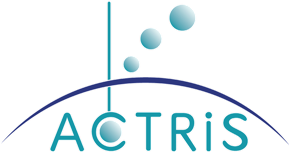

3) Select the first resource and go to Details. You will see all the information about the resource, namely, the endpoint to query Stations data.

<img src="actris2.png" width="400" height="600">

In [ ]:
response = requests.get('https://prod-actris-md.nilu.no/Stations') 
actris_df = pd.DataFrame(response.json())
actris_df.head(5)

In [ ]:
# Stylize popup

def actris_popup_html(row):
    i = row
    name=actris_df['name'].iloc[i]
    lat = actris_df['lat'].iloc[i]
    lon = actris_df['lon'].iloc[i]
    alt = actris_df['alt'].iloc[i]
    country_code=actris_df['country_code'].iloc[i]
    region=actris_df['wmo_region'].iloc[i]
    coordinates = []
    
    if actris_df['lat'].iloc[i] != None and actris_df['lon'].iloc[i] != None:
        coordinates = (actris_df['lat'].iloc[i], actris_df['lon'].iloc[i])
        
    left_col_color = "#19a7bd"
    right_col_color = "#f2f0d3"
    
    html = """<!DOCTYPE html>
<html>
<head>
<h4 style="margin-bottom:10"; width="300px">{}</h4>""".format(name) + """
</head>
<style type="text/css">
td {
  padding: 5px;
}
</style>
    <table style="height: 126px; width: 375px;">
<tbody>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Name</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(name) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Altitude</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(alt) + """
</tr>

<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Country code</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(country_code) + """
</tr>

<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Region</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(region) + """
</tr>

<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Coordinates</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(coordinates) + """
</tr>

<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;"></span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";"><img src="https://www.actris.eu/sites/default/files/inline-images/Actris%20logo.png" width="150" height="auto"></td>""""""
</tr>

</tbody>
</table>
</html>
"""
    return html

In [ ]:
# Add feature group
actris_fg=folium.FeatureGroup(name='ACTRIS', show=True)
my_map.add_child(actris_fg)

for index, row in actris_df.iterrows():
    html = actris_popup_html(index)
    popup = folium.Popup(folium.Html(html, script=True), max_width=500)
    folium.Marker(location=[row['lat'], row['lon']], popup = popup, icon=folium.Icon(color='orange', icon='cloud', prefix='fa')).add_to(actris_fg)

# **IAGOS**

IAGOS has an API you can use to query its data: https://services.iagos-data.fr/prod/swagger-ui/index.html .
IAGOS's stations are airports, thus, we'll be querying the service v2.0/airports, under "Airports service".

In [ ]:
REST_URL_STATIONS="https://services.iagos-data.fr/prod/v2.0/airports?active=true"

In [ ]:
def get_list_platforms():
    try:
        response = requests.get(REST_URL_STATIONS)
        response.raise_for_status()
        jsonResponse = response.json()
        ret = []
        for item in jsonResponse:
            
            if int(item['nb_profiles'] > 100):
                station={ 'short_name': item['iata_code'], 'long_name': item['name'], 'longitude': item['longitude'], 'latitude': item['latitude'], 'altitude': item['altitude']  }
                ret.append(station)
        return ret    
    except Exception as err:
        print(f'An error occurred: {err}')

In [ ]:
iagos_df = pd.DataFrame(get_list_platforms())
iagos_df

In [ ]:
# Stylize popup

def iagos_popup_html(row):
    i = row
    short_name=iagos_df['short_name'].iloc[i]
    long_name = iagos_df['long_name'].iloc[i]
    altitude = iagos_df['altitude'].iloc[i]
    
    if iagos_df['latitude'].iloc[i] != None and iagos_df['longitude'].iloc[i] != None:
        coordinates = (iagos_df['latitude'].iloc[i], iagos_df['longitude'].iloc[i])
        
    left_col_color = "#19a7bd"
    right_col_color = "#f2f0d3"
    
    html = """<!DOCTYPE html>
<html>
<head>
<h4 style="margin-bottom:10"; width="300px">{}</h4>""".format(long_name) + """
</head>
<style type="text/css">
td {
  padding: 5px;
}
</style>
    <table style="height: 126px; width: 375px;">
<tbody>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Short name</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(short_name) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Long name</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(long_name) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Altitude</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(altitude) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Coordinates</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(coordinates) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;"></span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";"><img src="https://www7.obs-mip.fr/wp-content-aeris/uploads/sites/66/2020/06/Logo_Color.png" width="150" height="auto"></td>""""""
</tr>
</tbody>
</table>
</html>
"""
    return html

In [ ]:
# Add feature group
iagos_fg=folium.FeatureGroup(name='IAGOS', show=True)
my_map.add_child(iagos_fg)

for index, row in iagos_df.iterrows():
    html = iagos_popup_html(index)
    popup = folium.Popup(folium.Html(html, script=True), max_width=500)
    icon = folium.features.CustomIcon('https://www7.obs-mip.fr/wp-content-aeris/uploads/sites/66/2020/06/iagos_icon.png', icon_size=(34, 34))
    folium.Marker(location=[row['latitude'], row['longitude']], popup = popup, icon=folium.Icon(color='darkpurple', icon='cloud', prefix='fa')).add_to(iagos_fg)
    


# **SIOS**

With SIOS, we'll be querying observation facilities(not necessarily providing data ).

SIOS Svalbard also has an API you can use: Go to [SIOS Catalogue](https://sios-svalbard.org/sios-ri-catalogue) and select the option "Export of data in machine readable format (REST API)". Use the URL that will open to query the service:

In [ ]:
def sios_observation_facilities():
    response = requests.get('https://sios-svalbard.org/sios-ri-catalogue/rest/sios-ri-catalogue.json')
    ofs = []
    ofs_list = []
    for of in response.json():
        if of['title'] not in ofs_list:
            ofs.append({'title': of['title'],
                        'station type': of['OF-Type'],
                        'geometry': of['OF-Coordinates'],
                        'station height': of['OF-Height'],
                        'institution': of['institution']})
            ofs_list.append(of['title'])
    sios_df = pd.DataFrame(ofs)

    return sios_df

In [ ]:
sios_df = sios_observation_facilities()

sios_df

In [ ]:
# Stylize popup

def sios_popup_html(row):
    i = row
    title=sios_df['title'].iloc[i]
    station_type=sios_df['station type'].iloc[i]
    coordinates=sios_df['geometry'].iloc[i]
    station_height=sios_df['station height'].iloc[i]
    institution=sios_df['institution'].iloc[i]
        
    left_col_color = "#19a7bd"
    right_col_color = "#f2f0d3"
    
    html = """<!DOCTYPE html>
<html>
<head>
<h4 style="margin-bottom:10"; width="300px">{}</h4>""".format(title) + """
</head>
<style type="text/css">
td {
  padding: 5px;
}
</style>
    <table style="height: 126px; width: 375px;">
<tbody>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Station Type</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(station_type) + """
</tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Coordinates</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(coordinates) + """
</tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Station Height</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(station_height) + """
</tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Institution</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(institution) + """
</tr>
<tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;"></span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";"><img src="https://envri.eu/wp-content/uploads/2019/10/Logo-SIOS-ORIGINAL-rgb-1024x669.png" width="150" height="auto"></td>""""""
</tr>
<tr>
</tbody>
</table>
</html>
"""
    return html

In [ ]:
# Add feature group
sios_fg=folium.FeatureGroup(name='SIOS', show=True)
my_map.add_child(sios_fg)

for index, row in sios_df.iterrows():
    html = sios_popup_html(index)
    popup = folium.Popup(folium.Html(html, script=True), max_width=500)
    folium.GeoJson(data=shapely.wkt.loads(sios_df["geometry"][index]), tooltip=row['title']).add_to(sios_fg)

# **EURO-ARGO**

EURO-ARGO is currently one of the RIs already catalogued in the ENVRI-Hub's Catalogue of Services. Search for "Seadatanet - Sextant SPARQL Endpoint" and in the details, you will see "Endpoint: https://sparql.ifremer.fr/sextant_seadatanet/query={?query}"

Unlike the rest of the APIs we use in this notebook, EURO-ARGO's provides a [SPARQL](https://www.ontotext.com/knowledgehub/fundamentals/what-is-sparql/) endpoint. If you are not familiar with the semantic web, don't worry, this is a good time to learn!

In [ ]:
# EURO-ARGO


endpoint = "https://sparql.ifremer.fr/argo/query"

q = """
   prefix geo: <https://www.w3.org/2003/01/geo/wgs84_pos#> 
prefix owl: <http://www.w3.org/2002/07/owl#> 
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
prefix ssn: <http://www.w3.org/ns/ssn/> 
prefix xml: <http://www.w3.org/XML/1998/namespace> 
prefix xsd: <http://www.w3.org/2001/XMLSchema#> 
prefix argo: <http://www.argodatamgt.org/argo-ontology#> 
prefix foaf: <http://xmlns.com/foaf/0.1/> 
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
prefix sosa: <http://www.w3.org/ns/sosa/>
prefix nerc: <http://vocab.nerc.ac.uk/collection/>
prefix dct: <http://purl.org/dc/terms/>
prefix prov: <https://www.w3.org/TR/prov-o/>

# stations/date of each cycle
SELECT distinct ?wmo ?lat ?lon ?date where{
 ?float argo:cycle ?cycle;
        argo:wmoCode ?wmo.
 ?cycle geo:latitude ?lat;
        geo:longitude ?lon;
        argo:startDate ?date.
}
"""

argo_df = sparql_dataframe.get(endpoint, q)
argo_df = argo_df.drop(argo_df[(argo_df['lat'] == 'None') | (argo_df['lon'] == 'None')].index)

# EURO-ARGO's stations are floats, and they count with thousands! 
# If we choose to render them all, the notebook processing will become slow, so for computational time's sake,
# we'll limit the dataset to 1000 stations:
argo_df_subset = argo_df.iloc[0:1000]

argo_df_subset

In [ ]:
# Stylize popup

def argo_popup_html(row):
    i = row 
    left_col_color = "#19a7bd"
    right_col_color = "#f2f0d3"
    coordinates = (argo_df_subset['lat'].iloc[i], argo_df_subset['lon'].iloc[i])
    date = argo_df_subset['date'].iloc[i]
    html = """<!DOCTYPE html>
<html>
<head>
<h4 style="margin-bottom:10"; width="300px">EURO-ARGO float, {}</h4>""".format(date) + """
</head>
<style type="text/css">
td {
  padding: 5px;
}
</style>
    <table style="height: 126px; width: 375px;">
<tbody>
<tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Coordinates</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(coordinates) + """
</tr>

<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;"></span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";"><img src="https://www.euro-argo.eu/var/storage/images/_aliases/opengraphimage/medias-ifremer/medias-euro_argo/logos/euro-argo-logo-g/1629679-1-eng-GB/Euro-Argo-logo-G.png" width="150" height="auto"></td>""""""
</tr>
</tbody>
</table>
</html>
"""
    return html

In [ ]:
# Add feature group

argo_fg=folium.FeatureGroup(name='EURO-ARGO', show=True)
my_map.add_child(argo_fg)


for idx, row in argo_df_subset.iterrows():
    icon = folium.features.CustomIcon("https://cdn-icons-png.flaticon.com/512/1833/1833932.png",
                                      icon_size=(34, 34))
    html = argo_popup_html(idx)
    argo_popup = folium.Popup(folium.Html(html, script=True), max_width=500)
    folium.Marker(location=[row['lat'], row['lon']], popup = argo_popup, icon=icon).add_to(argo_fg)
    

In [ ]:
folium.LayerControl().add_to(my_map)
my_map

In [ ]:
my_map.save("envri_stations_preview.html")